In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "ravdess-emotional-speech-audio"

# EmotionTrack Tutor Voice classication project
## Problem definition
The objective of this project is to develop a Semi-Structured Distributional Regression (SSMR) model capable of detecting and classifying a user's emotion into Paul Ekman's Six Universal Emotions: Anger, Disgust, Enjoyment, Fear, Sadness, and Surprise from a user's voice. This model will serve as an audio detection classifier and will be integrated into the EmotionTrack Tutor app, an educational platform designed for Android devices that utilizes virtual reality (VR) environments. The app aims to engage users emotionally during their learning process through interactive simulations, while reducing the effects of the uncanny valley —a phenomenon where human-like avatars evoke discomfort due to subtle imperfections in realism.

## Data
The source of the dataset used in this project was https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio.

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) includes speech audio-only files (.wav format, 16-bit, 48kHz). The complete dataset, featuring both speech and song in audio and video format, is available on Zenodo (24.8 GB). The development and perceptual validation of RAVDESS are detailed in an Open Access paper in PLoS ONE.

This subset contains 1,440 files, consisting of 60 trials per actor across 24 actors (12 male, 12 female). Each actor vocalizes two lexically-matched statements in a neutral North American accent. The dataset captures various emotions, including calm, happy, sad, angry, fearful, surprised, and disgusted, with each emotion expressed at two intensity levels (normal and strong), along with a neutral expression.


## Evaluation
After training, both models were evaluated on the test set using categorical cross-entropy as the loss function and accuracy as the key performance metric.

## Feature
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12)

Female, as the actor ID number is even.


In [2]:
# List of required libraries
required_libraries <- c("tidymodels","readr","keras","tensorflow","reticulate","parallel","tidyverse","abind","caret","tuneR","warbleR","voice","e1071","pheatmap","RColorBrewer")

install.packages(required_libraries)

#Import the packages
library(tidymodels)
library(readr)
library(keras)
library(tensorflow)
library(reticulate)
library(parallel)
library(tidyverse)
library(abind)
library(caret)
library(tuneR)
library(warbleR)
#library(av)
library(voice)
library(e1071)
library(pheatmap)
library(RColorBrewer)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘parallel’ is a base package, and should not be updated”
also installing the dependency ‘wrassp’


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.4.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/


Attaching package: ‘keras’


The fol

In [3]:
#path to the dataset 
dataset_path <- "/kaggle/input/ravdess-emotional-speech-audio"

In [4]:
#Load the audio files and extract features
actors <- list.files(dataset_path, pattern = "Actor_")
audio_data <- data.frame()

In [5]:
install.packages("seewave")

In [6]:
library(seewave)

In [7]:
# Loop through the actor folders to process each audio file
for (actor in actors) {
  actor_path <- file.path(dataset_path, actor)
  audio_files <- list.files(actor_path, full.names = TRUE)
  
  for (file in audio_files) {
    audio <- readWave(file)
    if (audio@stereo) {
      audio_left <- mono(audio, which = "left")
    } else {
      audio_left <- audio  
    }
    mfcc <- melfcc(audio_left, numcep = 13)  
    filename <- basename(file)
    parts <- strsplit(filename, "-")[[1]]
    
    emotion <- as.numeric(parts[4])  
    intensity <- as.numeric(parts[5])  
    audio_data <- rbind(audio_data, data.frame(mfcc = list(mfcc), emotion = emotion, intensity = intensity))
  }
}


head(audio_data)


,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13,emotion,intensity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-55.65969,-14.78637,1.9436710,1.681781,1.61827090,-2.5351807,-0.8494959,1.631342,-2.2989825,-1.4888298,1.1869798,-7.9392774,-4.6182781,1,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,-64.90571,-14.58476,-1.5807126,-3.423071,-1.63667404,-2.0198712,-1.2587187,-1.277769,-0.8172010,-0.7850666,-0.5143302,-0.5144588,-0.3598341,1,1
4,-34.06683,-14.61294,-1.6154277,-3.458529,-1.67107016,-2.0525177,-1.2891828,-1.305778,-0.8426333,-0.8079574,-0.5348228,-0.5327636,-0.3761751,1,1
5,-42.36358,-14.39819,-0.4569441,-1.677881,0.09983198,-0.2097931,0.5345783,0.821459,0.5563097,0.9743843,0.8321990,-0.3734664,0.9128459,1,1
6,-23.15175,-14.85311,-0.4113058,-1.942709,0.18665391,1.7897112,3.2663857,4.953616,2.6976055,2.8000589,3.1326864,-1.6084747,0.3052782,1,1


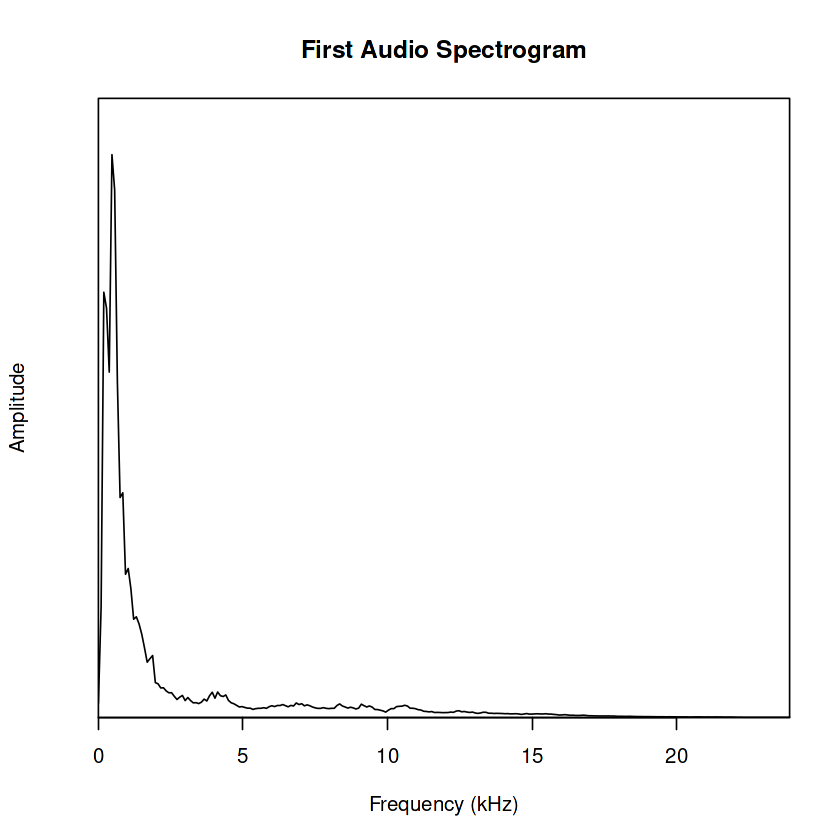

In [49]:
first_audio <- readWave(audio_files[1])
first_fft <- meanspec(first_audio, f = first_audio@samp.rate, wl = 512, ovlp = 75, plot = TRUE, main = "First Audio Spectrogram")

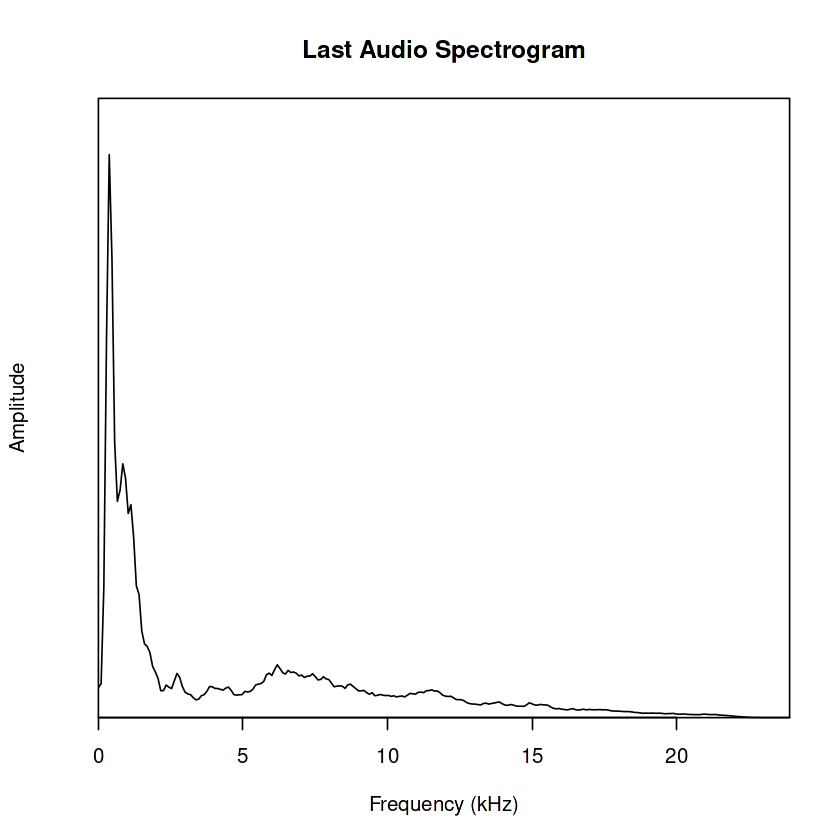

In [50]:
last_audio <- readWave(audio_files[length(audio_files)])
last_fft <- meanspec(last_audio, f = last_audio@samp.rate, wl = 512, ovlp = 75, plot = TRUE, main = "Last Audio Spectrogram")


In [8]:
nrow(audio_data)

[1] 529973

In [9]:
sum(!complete.cases(audio_data))

[1] 24805

In [10]:
audio_data_clean <- audio_data[complete.cases(audio_data), ]
sum(is.na(audio_data_clean))

[1] 0

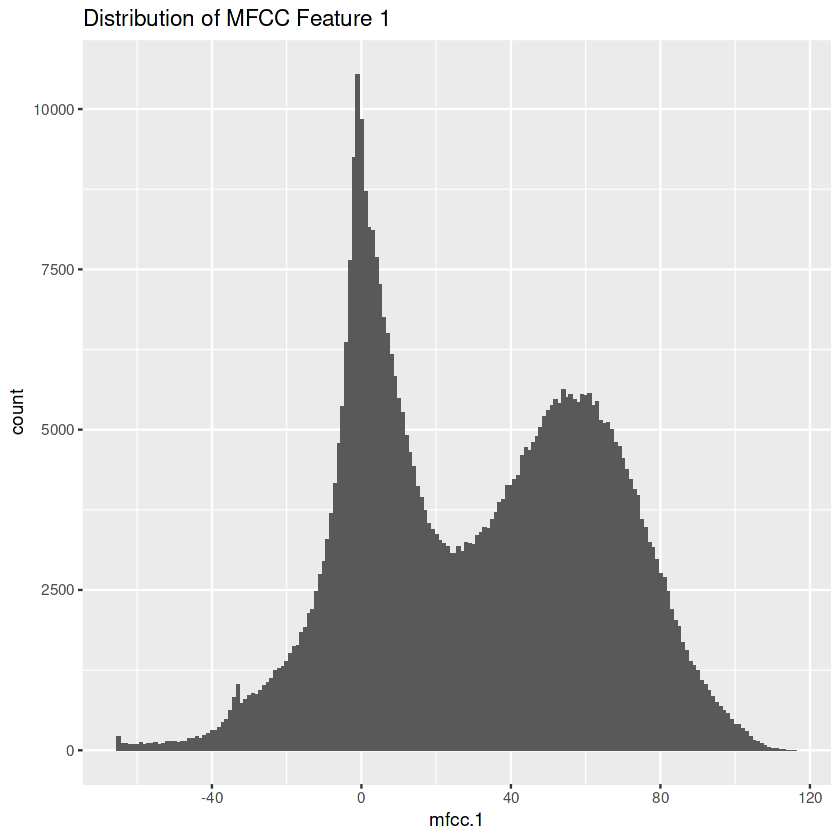

In [11]:
ggplot(audio_data_clean, aes(x = mfcc.1)) + 
  geom_histogram(binwidth = 1) + 
  ggtitle("Distribution of MFCC Feature 1")

In [12]:
str(audio_data_clean$mfcc.1)

 num [1:505168] -55.7 -64.9 -34.1 -42.4 -23.2 ...


In [13]:
head(audio_data_clean)

,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13,emotion,intensity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-55.65969,-14.78637,1.9436710,1.681781,1.61827090,-2.5351807,-0.8494959,1.631342,-2.2989825,-1.4888298,1.1869798,-7.9392774,-4.6182781,1,1
3,-64.90571,-14.58476,-1.5807126,-3.423071,-1.63667404,-2.0198712,-1.2587187,-1.277769,-0.8172010,-0.7850666,-0.5143302,-0.5144588,-0.3598341,1,1
4,-34.06683,-14.61294,-1.6154277,-3.458529,-1.67107016,-2.0525177,-1.2891828,-1.305778,-0.8426333,-0.8079574,-0.5348228,-0.5327636,-0.3761751,1,1
5,-42.36358,-14.39819,-0.4569441,-1.677881,0.09983198,-0.2097931,0.5345783,0.821459,0.5563097,0.9743843,0.8321990,-0.3734664,0.9128459,1,1
6,-23.15175,-14.85311,-0.4113058,-1.942709,0.18665391,1.7897112,3.2663857,4.953616,2.6976055,2.8000589,3.1326864,-1.6084747,0.3052782,1,1
7,-42.18709,-14.86227,-1.2106583,-4.070364,-0.88375833,2.4000024,2.9826995,6.212928,2.7170610,2.1389853,4.3325098,-1.5469794,-0.9265633,1,1


In [51]:
# Extract MFCC features as a matrix
X <- as.matrix(audio_data_clean[, grep("^mfcc\\.", names(audio_data_clean))])
cat("MFCC Matrix:\n")
print(head(X))

MFCC Matrix:
     mfcc.1    mfcc.2     mfcc.3    mfcc.4      mfcc.5     mfcc.6     mfcc.7
1 -55.65969 -14.78637  1.9436710  1.681781  1.61827090 -2.5351807 -0.8494959
3 -64.90571 -14.58476 -1.5807126 -3.423071 -1.63667404 -2.0198712 -1.2587187
4 -34.06683 -14.61294 -1.6154277 -3.458529 -1.67107016 -2.0525177 -1.2891828
5 -42.36358 -14.39819 -0.4569441 -1.677881  0.09983198 -0.2097931  0.5345783
6 -23.15175 -14.85311 -0.4113058 -1.942709  0.18665391  1.7897112  3.2663857
7 -42.18709 -14.86227 -1.2106583 -4.070364 -0.88375833  2.4000024  2.9826995
     mfcc.8     mfcc.9    mfcc.10    mfcc.11    mfcc.12    mfcc.13
1  1.631342 -2.2989825 -1.4888298  1.1869798 -7.9392774 -4.6182781
3 -1.277769 -0.8172010 -0.7850666 -0.5143302 -0.5144588 -0.3598341
4 -1.305778 -0.8426333 -0.8079574 -0.5348228 -0.5327636 -0.3761751
5  0.821459  0.5563097  0.9743843  0.8321990 -0.3734664  0.9128459
6  4.953616  2.6976055  2.8000589  3.1326864 -1.6084747  0.3052782
7  6.212928  2.7170610  2.1389853  4.3325098 -

In [53]:
# Extract emotion labels
Y <- audio_data_clean$emotion
cat("Emotion Labels:\n")
print(head(Y))
print(tail(Y))

Emotion Labels:
[1] 1 1 1 1 1 1
[1] 2 2 2 2 2 2


In [15]:
# Split the dataset into training, validation and test sets
set.seed(12345)
trainIndex <- createDataPartition(Y, p = 0.7, list = FALSE)
trainX <- X[trainIndex,]
trainY <- Y[trainIndex]
valTestX <- X[-trainIndex,]
valTestY <- Y[-trainIndex]

In [16]:
head(trainX)
head(trainY)
head(valTestX)
head(valTestY)

,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13
1,-55.65969,-14.78637,1.9436710,1.681781,1.6182709,-2.535181,-0.8494959,1.6313417,-2.2989825,-1.4888298,1.1869798,-7.9392774,-4.6182781
3,-64.90571,-14.58476,-1.5807126,-3.423071,-1.6366740,-2.019871,-1.2587187,-1.2777688,-0.8172010,-0.7850666,-0.5143302,-0.5144588,-0.3598341
7,-42.18709,-14.86227,-1.2106583,-4.070364,-0.8837583,2.400002,2.9826995,6.2129277,2.7170610,2.1389853,4.3325098,-1.5469794,-0.9265633
8,-25.40668,-14.04619,-0.5653920,-1.215053,2.1561004,-3.662799,-4.9037337,-5.2459535,3.2648618,3.7973271,0.2531946,0.3497233,1.6443193
10,-25.26143,-12.68638,0.6537282,-2.756552,-2.6992517,2.688181,1.7795684,-2.4112007,-0.3096316,2.1925269,-2.7853345,-0.7414532,-1.4319550
11,-18.85780,-12.52789,0.7018314,-3.015286,-2.8658995,2.865699,1.3723203,-0.7329435,0.1003722,2.8491683,-1.5598727,-1.2131841,1.9122469


[1] 1 1 1 1 1 1

,mfcc.1,mfcc.2,mfcc.3,mfcc.4,mfcc.5,mfcc.6,mfcc.7,mfcc.8,mfcc.9,mfcc.10,mfcc.11,mfcc.12,mfcc.13
4,-34.06683,-14.61294,-1.6154277,-3.4585290,-1.67107016,-2.0525177,-1.28918283,-1.3057780,-0.8426333,-0.8079574,-0.5348228,-0.5327636,-0.3761751
5,-42.36358,-14.39819,-0.4569441,-1.6778814,0.09983198,-0.2097931,0.53457833,0.8214590,0.5563097,0.9743843,0.8321990,-0.3734664,0.9128459
6,-23.15175,-14.85311,-0.4113058,-1.9427086,0.18665391,1.7897112,3.26638573,4.9536163,2.6976055,2.8000589,3.1326864,-1.6084747,0.3052782
9,-20.83345,-14.31494,-0.2316108,-1.9679672,1.30446005,-1.7184639,-4.95958115,-4.9774894,-0.1246791,0.6777399,-2.3391566,2.7375138,0.3869628
12,-29.00864,-15.32851,0.7824696,-0.6029482,1.04483189,-1.4641710,-8.04925125,-2.4157076,7.3520076,9.4559508,5.0061664,2.2975550,2.8584407
15,-29.01050,-14.69037,-1.7101947,-3.8335202,-0.90482537,-0.8355819,0.02512984,-0.4126448,-1.7189032,-1.4045187,-0.1070335,1.0352797,-0.7026399


[1] 1 1 1 1 1 1

In [17]:
# Further split validation and test sets
valIndex <- createDataPartition(valTestY, p = 0.5, list = FALSE)
valX <- valTestX[valIndex,]
valY <- valTestY[valIndex]
testX <- valTestX[-valIndex,]
testY <- valTestY[-valIndex]

In [18]:
# Normalize the data
trainX <- scale(trainX)
valX <- scale(valX, center = attr(trainX, "scaled:center"), scale = attr(trainX, "scaled:scale"))
testX <- scale(testX, center = attr(trainX, "scaled:center"), scale = attr(trainX, "scaled:scale"))

In [19]:
# Convert labels to categorical
num_classes <- 8
trainY <- to_categorical(trainY - 1, num_classes = num_classes)
valY <- to_categorical(valY - 1, num_classes = num_classes)
testY <- to_categorical(testY - 1, num_classes = num_classes)

In [23]:
# Define the model 
model <- keras_model_sequential() %>% 
  layer_dense(units = 128, activation = 'relu', input_shape = ncol(trainX)) %>%  
  layer_dropout(rate = 0.3) %>% 
  layer_dense(units = 64, activation = 'relu') %>%  
  layer_dropout(rate = 0.3) %>% 
  layer_dense(units = num_classes, activation = 'softmax')

# Compile the model
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

In [54]:
summary(model)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_6 (Dense)                    (None, 128)                     1792        
 dropout_4 (Dropout)                (None, 128)                     0           
 dense_5 (Dense)                    (None, 64)                      8256        
 dropout_3 (Dropout)                (None, 64)                      0           
 dense_4 (Dense)                    (None, 8)                       520         
Total params: 10,568
Trainable params: 10,568
Non-trainable params: 0
________________________________________________________________________________


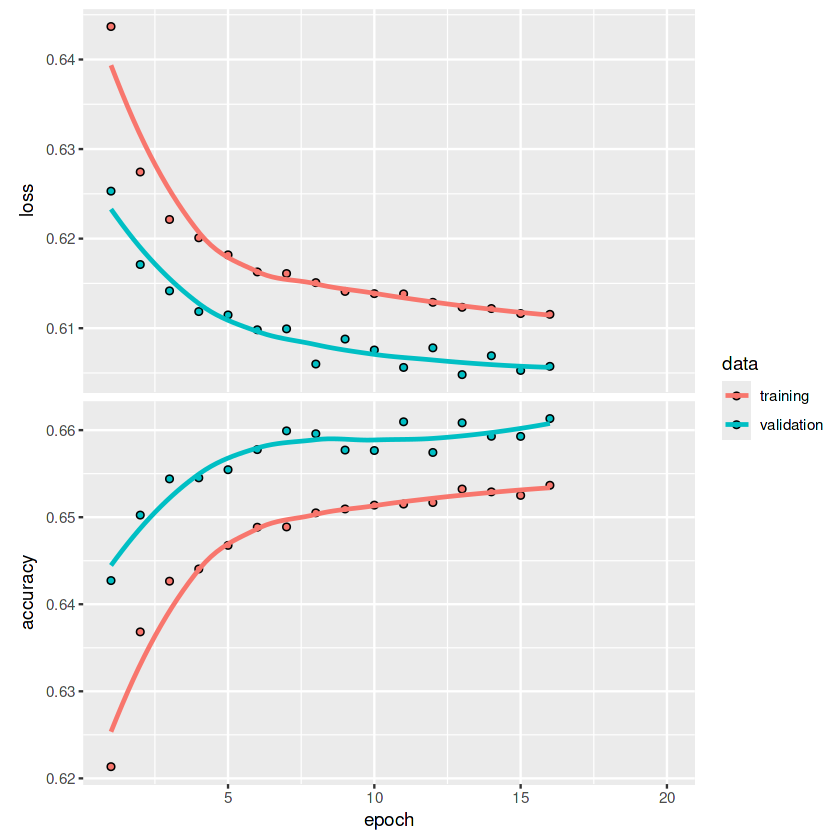

In [24]:
# Train the model 
history <- model %>% fit(
  x = trainX, y = trainY,
  epochs = 20, 
  batch_size = 32,
  validation_data = list(valX, valY),
  callbacks = list(
    callback_early_stopping(monitor = "val_loss", patience = 3, restore_best_weights = TRUE)
  )
)

# Plot training history
plot(history)

From the above plot we can see  that both training and validation loss are decreasing as the number of epochs increases, but the validation loss is consistently higher than the training loss.

In [25]:
# Evaluate the model on the test set
test_eval <- model %>% evaluate(testX, testY)
test_accuracy <- test_eval[["accuracy"]]

# Display the test accuracy
cat('Test accuracy:', test_accuracy, '\n')

Test accuracy: 0.6549522 


### To confirm the above value of accuracy

In [26]:
predProb <- predict(model, testX)
predClass <- apply(predProb, 1, which.max) - 1 
trueClass <- apply(testY, 1, which.max) - 1

In [55]:
Confusion_matrix <- confusionMatrix(factor(predClass, levels = 0:(num_classes-1)),
                               factor(trueClass, levels = 0:(num_classes-1)))

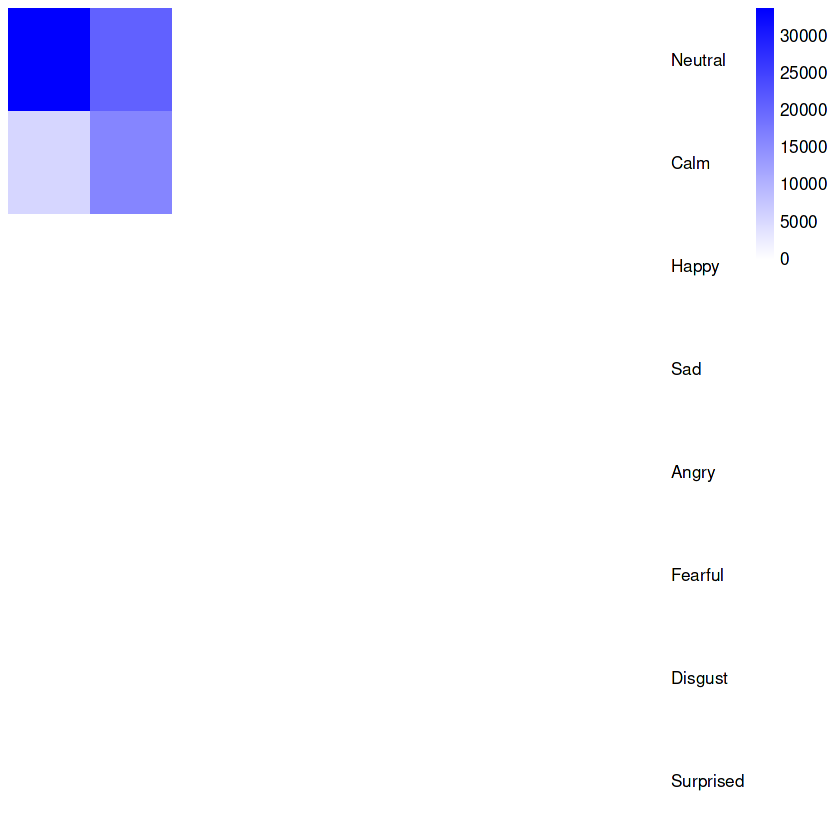

In [57]:
pheatmap(Confusion_matrix$table, cluster_rows = F, cluster_cols = F,
         border_color = NA, show_colnames = F,
         labels_row = c("Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"),
         color = colorRampPalette(c("white", "blue"))(max(Confusion_matrix$table) + 1))


In [29]:
# Accuracy on the test set
cat('Test set accuracy:', mean(predClass == trueClass), '\n')

Test set accuracy: 0.6549522 


In [58]:
# Create a tibble to show the probability of each emotion and the actual class
results <- tibble(
  Sample = 1:nrow(predProb),
  Predicted_Class = factor(predClass, levels = 0:(num_classes-1), 
                            labels = c("Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised")),
  Actual_Class = factor(trueClass, levels = 0:(num_classes-1), 
                         labels = c("Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised")),
  Predicted_Probabilities = I(lapply(1:nrow(predProb), function(i) predProb[i, ]))
)

print(head(results))

# A tibble: 6 × 4
  Sample Predicted_Class Actual_Class Predicted_Probabilities
   <int> <fct>           <fct>        <I<list>>              
1      1 Neutral         Neutral      <dbl [8]>              
2      2 Neutral         Neutral      <dbl [8]>              
3      3 Neutral         Neutral      <dbl [8]>              
4      4 Neutral         Neutral      <dbl [8]>              
5      5 Neutral         Neutral      <dbl [8]>              
6      6 Neutral         Neutral      <dbl [8]>              


In [31]:
#Saving the model
model %>% save_model_hdf5("voice_cnn.h5")

### SSDR

In [35]:
# Load the already created CNN model
first_cnn <- load_model_hdf5("voice_cnn.h5")

### Define the SSDR model

In [60]:
input_shape <- ncol(trainX)
print(input_shape)

[1] 13


In [37]:
# Input layer
input <- layer_input(shape = input_shape)

# Structured linear part (fk,0(x))
linear_part <- layer_dense(input, units = 64, activation = 'linear') 

# Nonlinear part (fk,j(zj))
nonlinear_part <- layer_dense(input, units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.3)

# Unstructured part (dk,j(u)) using DNN
unstructured_part <- layer_dense(input, units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dropout(rate = 0.3)

# Additive combination of structured and unstructured parts
combined <- layer_add(list(linear_part, nonlinear_part, unstructured_part))

# Output layer for classification
output <- layer_dense(combined, units = num_classes, activation = 'softmax')

In [38]:
# Define the SSDR model
ssdr_model <- keras_model(inputs = input, outputs = output)

# Compile the SSDR model
ssdr_model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

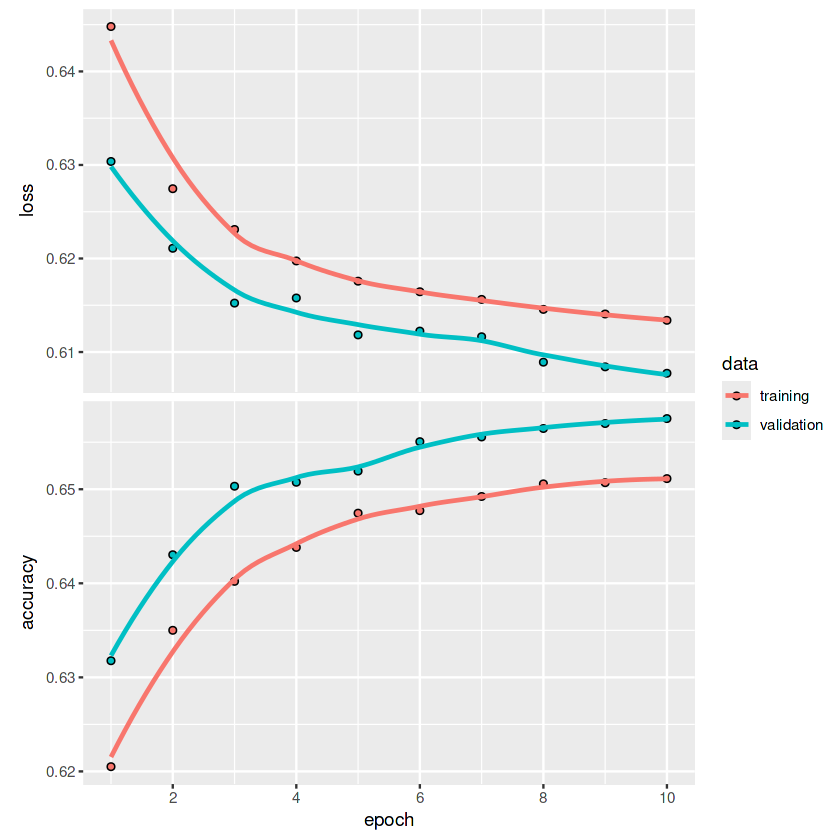

In [39]:
# Train the SSDR model
history_ssdr <- ssdr_model %>% fit(
  trainX, trainY,  
  epochs = 10,
  batch_size = 32,
  validation_data = list(valX, valY) 
)
plot(history_ssdr)

In [40]:
#compare the two models built
cnn_eval <- first_cnn %>% evaluate(testX, testY)  
ssdr_eval <- ssdr_model %>% evaluate(testX, testY)  
cat("Original CNN Accuracy:", cnn_eval[["accuracy"]], "\n")
cat("SSDR Model Accuracy:", ssdr_eval[["accuracy"]], "\n")

Original CNN Accuracy: 0.6549522 
SSDR Model Accuracy: 0.6535269 


In [43]:
# Save the SSDR model 
save_model_hdf5(ssdr_model, "ssdr_voice_model.h5")

## Saving the Two models as tensow lite for deployment

In [44]:
tf <- import("tensorflow")

In [45]:
cnn_converter <- tf$lite$TFLiteConverter$from_keras_model(first_cnn)
cnn_tflite_model <- cnn_converter$convert()
cnn_tflite_model_raw <- serialize(cnn_tflite_model, NULL)
cnn_tflite_path <- "cnn_voice_model.tflite"
writeBin(cnn_tflite_model_raw, cnn_tflite_path)
cat("CNN Model has been converted and saved as 'cnn_voice_model.tflite'.\n")

CNN Model has been converted and saved as 'cnn_voice_model.tflite'.


In [46]:
ssdr_converter <- tf$lite$TFLiteConverter$from_keras_model(ssdr_model)
ssdr_tflite_model <- ssdr_converter$convert()
ssdr_tflite_model_raw <- serialize(ssdr_tflite_model, NULL)
ssdr_tflite_path <- "ssdr_voice_model.tflite"
writeBin(ssdr_tflite_model_raw, ssdr_tflite_path)
cat("SSDR Model has been converted and saved as 'ssdr_voice_model.tflite'.\n")

SSDR Model has been converted and saved as 'ssdr_voice_model.tflite'.
